[IEEE ICMLA 2019](https://www.icmla-conference.org/icmla19/)

[The Data Science landscape: foundations, tools, and practical applications](https://www.icmla-conference.org/icmla19/links/tutorialAM.htm)

# Statistics and Data Science

We will continue working with the _salaries_ dataset:

In [1]:
import pandas as pd

salaries = pd.read_csv("data/salaries.csv")
salaries.head()

,earn,height,sex,ed,age,race
0,50000.0,74.424439,male,16,45,white
1,60000.0,65.537543,female,16,58,white
2,30000.0,63.629198,female,16,29,white
3,50000.0,63.108562,female,16,91,other
4,51000.0,63.402484,female,17,39,white


Our objective is to check if there are signs of gender discrimination in salaries.

We will explore the dataset graphically for possible indications of gender discrimination (or not) in the salaries.

Our working hypothesis is that employees performing the same function should have similar salaries. However, the dataset does not list the function of each employee. We will use proxies for that. Two candidates for proxies are `age` and `ed`.

We will use plots in this section. Let's import the plotting libraries and setup the notebook plotting environment.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Use this line for presentations
# sns.set(context='talk')
# Use this line for online view (e.g. GitHub commits)
sns.set()

## Cleaning up the dataset

Before we delve into the dataset details, we need to clean it up a bit.

In the previous section, we noticed that we have low values for education and high values for age. We will inspect those values more closely and remove them if the analysis so warrants.

The goal of this step is to remove outliers from the dataset before we proceed with the investigations. Removing outliers focus the investigations on the samples that are more significant for the question we are answering.

### Cleaning up the `age` column

The summary statistics for the the `age` column, that we saw in the previous section, already showed that it is [right skewed](https://www.itl.nist.gov/div898/handbook/eda/section3/histogr6.htm):

In [3]:
salaries.age.describe()

count    1192.000000
mean       41.378356
std        15.867428
min        18.000000
25%        29.000000
50%        38.000000
75%        51.000000
max        91.000000
Name: age, dtype: float64

We can confirm that with the skew value:

In [4]:
print(salaries.age.skew())

0.7881214793675859


And visualize it with a distribution plot:

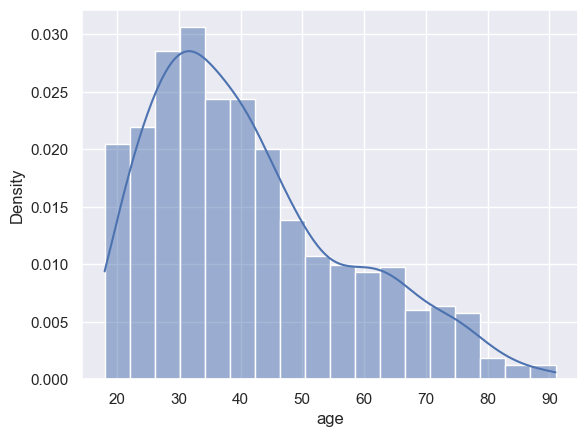

In [5]:
sns.histplot(salaries.age, stat="density", kde=True);

Note for plots: we will generally use [seaborn](https://seaborn.pydata.org/), a plotting library based on Matplotlib. It takes care of a few things, including axis labels and other formatting options that need to be explicitly set with Matplotlib.

For such a skewed distribution, a [box plot](https://en.wikipedia.org/wiki/Box_plot) makes the point even clearer. It shows where the quartiles are and the presence of outliers.

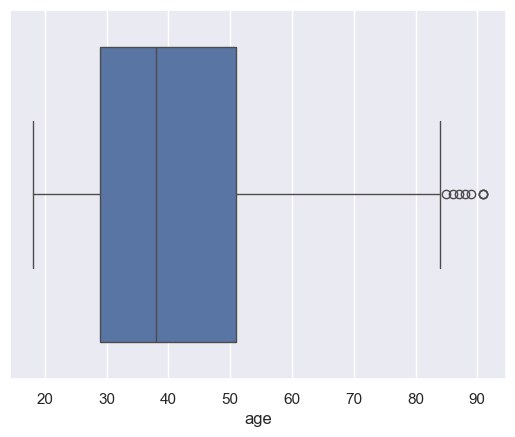

In [6]:
sns.boxplot(x=salaries.age);

We want to concentrate our analysis on the range of ages that encompasses most of the employees.

We could simply remove the outliers (starting just over 80 years of age), but that would still leave most of the 70 to 80 range. That range is also thinly represented in the dataset.

To take care of that, we will use 66 as the cutoff age for our analysis, for two reasons:

- It will remove most of the right tail, the range with few samples.
- It is the high side of the statutory retirement age in [most of the Western European countries](https://www.ssa.gov/policy/docs/progdesc/ssptw/2016-2017/europe/ssptw16europe.pdf) and in the United States (as of late 2019). We are using the Europe and US age because we are not sure what country this is, but the salary range is consistent with those countries.

The assumption behind this cutoff value is that employees working past the statutory retirement age are working under different conditions than younger employees, possibly fewer hours or highly compensated, critical employees. Either way, they would skew the analysis if left in the dataset.

In [7]:
AGE_CUTOFF = 66
over_age_cutoff = salaries.age >= AGE_CUTOFF
salaries = salaries[~over_age_cutoff]

print("{} employees are over {} years old".format(over_age_cutoff.sum(), AGE_CUTOFF))
print("{} employees are left to analyze".format(len(salaries)))

120 employees are over 66 years old
1072 employees are left to analyze


After the cleanup, the distribution looks like this:

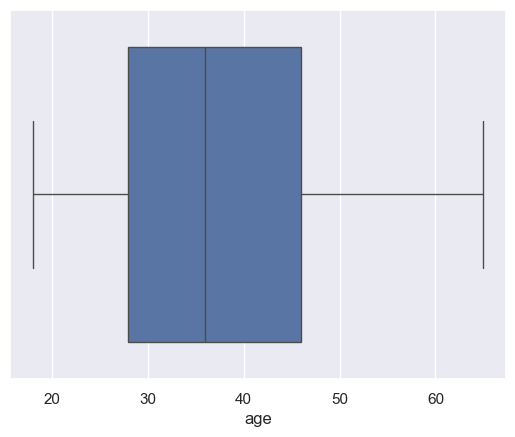

In [8]:
sns.boxplot(x=salaries.age);

### Cleaning up the `ed` column

We will now do the same for the `ed`, starting right away with a box plot:

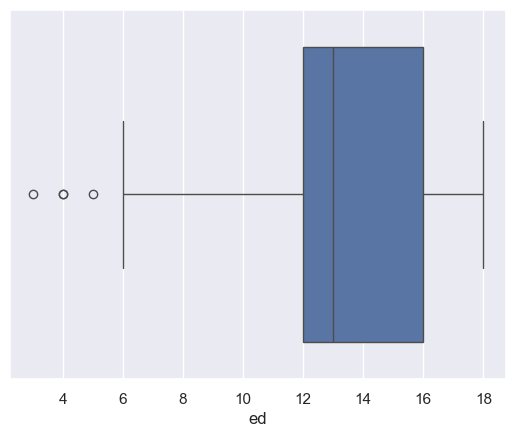

In [9]:
sns.boxplot(x=salaries.ed);

The box plot shows that the education distribution is left-skewed, with a few outliers.

We will use 12 years of education as our cutoff because [this is the number of years to finish high school in most countries](https://en.wikipedia.org/wiki/Educational_stage).

The assumption behind this cutoff value is that employees working before they complete high school are part-time employees, working different numbers of hours, possibly in different shifts. That variance would also skew the analysis if left in the dataset.

In [10]:
ED_CUTOFF = 12
below_ed_cutoff = salaries.ed < ED_CUTOFF
salaries = salaries[~below_ed_cutoff]

print(
    "{} employees have less than {} years of education".format(
        below_ed_cutoff.sum(), ED_CUTOFF
    )
)
print("{} employees are left to analyze".format(len(salaries)))

81 employees have less than 12 years of education
991 employees are left to analyze


After the cleanup, the distribution looks like this:

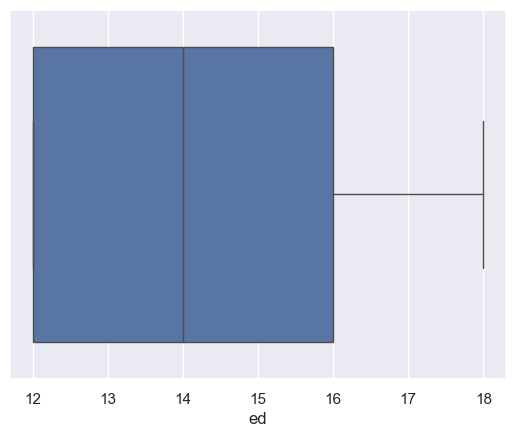

In [11]:
sns.boxplot(x=salaries.ed);

### Cleaning up the `height` column

Although there are indications that taller people make more money, the difference is small and applies to both men and women, with a slightly more pronounced effect for men ([source 1](https://en.wikipedia.org/wiki/Height_discrimination), [source 2](https://www.theatlantic.com/business/archive/2015/05/the-financial-perks-of-being-tall/393518/)).

Because of the small effect and the fact that it applies to both men and women, we will remove the `height` column to reduce noise in the remainder of the analysis.

In [12]:
salaries.drop("height", axis="columns", inplace=True)
salaries.columns

Index(['earn', 'sex', 'ed', 'age', 'race'], dtype='object')

## Checking if the dataset is balanced

Now that the dataset is cleaned up, we need to check if both genders are similarly represented. A gender-skewed dataset is still useful for the analysis, but makes it more difficult.

We will need to refer to female and male samples separately several times. Create separate datasets for each gender to make code simpler and to avoid copy-and-paste mistakes.

In [13]:
female_filter = salaries.sex == "female"
salaries_female = salaries[female_filter]
salaries_male = salaries[~female_filter]

In [14]:
print(
    "The dataset has {} female and {} male samples".format(
        len(salaries_female), len(salaries_male)
    )
)

The dataset has 576 female and 415 male samples


Now, plot the distribution of age across genders.

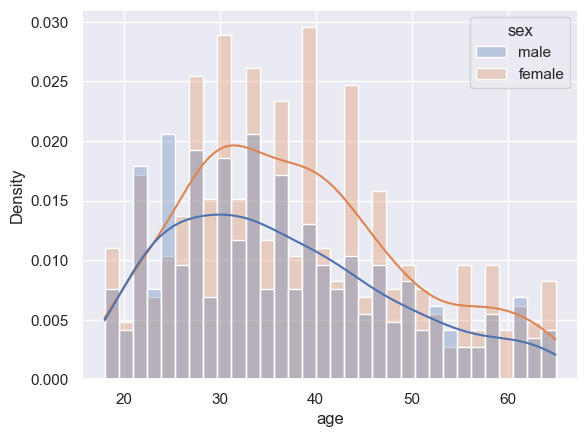

In [15]:
def histplot_column(column):
    sns.histplot(
        data=salaries,
        x=column,
        hue="sex",
        stat="density",
        bins="sqrt",
        kde=True,
        alpha=0.3,
    )
    plt.show()


histplot_column("age")

Then, plot the distribution of education levels across genders.

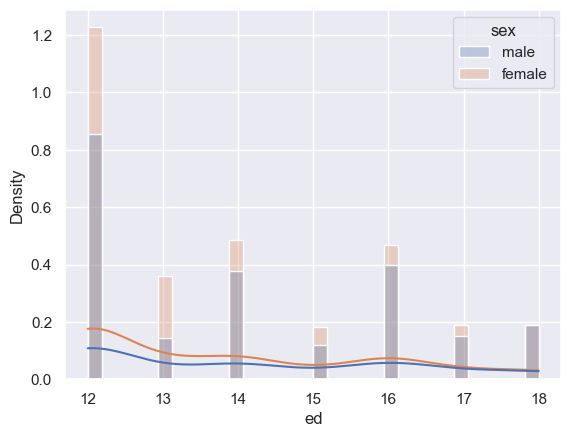

In [16]:
histplot_column("ed")

We can observe in the distributions that:

- The number of females in the dataset is about one third more than the number of males. It is a significant difference, but not yet concerning.
- The age distribution is about the same, with males slightly younger.
- The education distribution is about the same.

## Taking a first detailed look

We will start with an overview of the relationships among the features (columns), split by sex.

The plot below is a pairwise plot of all features in the dataset, using [seaborn's pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html). The `hue` parameters splits the graph by sex and the `alpha` parameter allows us to see concentrations of samples (darker vs. lighter colors). The diagonal is a KDE plot of the feature (a smoothed probability density function plot that helps visualizing the distribution).

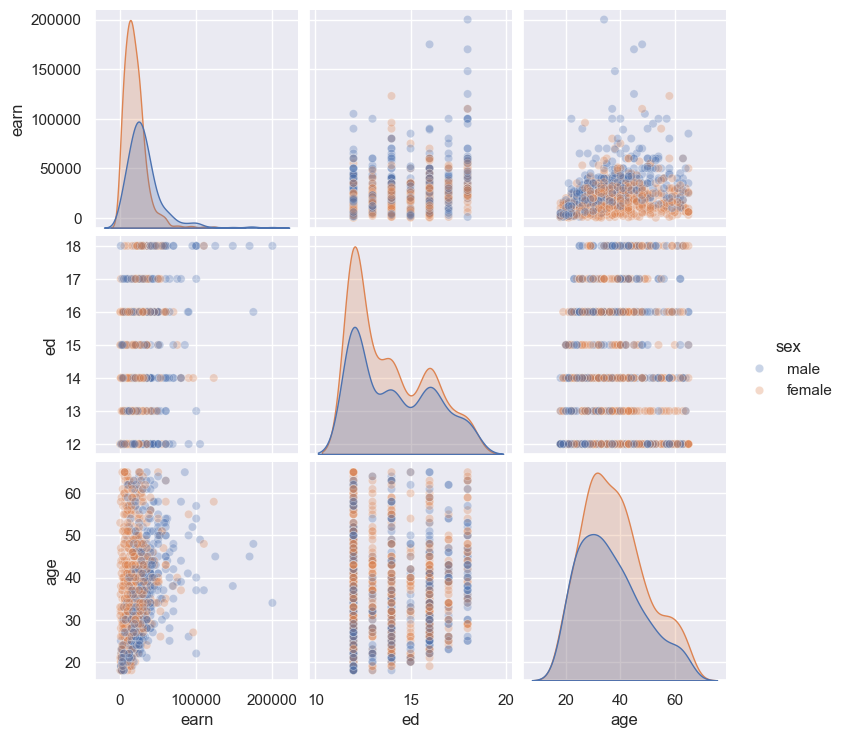

In [17]:
sns.pairplot(salaries, hue="sex", plot_kws=dict(alpha=0.3));

From the pairplots we can spot a few pieces of information. The text below refers to graphs by (_row_, _column_), for example (`earn`, `ed`) is the graph in the first row (`earn`), third column (`ed`).

- (`earn`, `earn`): the distribution shows that females earn less than males in general.
- (`earn`, `ed`): this scatter plot indicates that for the same education level, males earn more.
- (`earn`, `age`): this scatter plot indicates that for the same age, males earn more.
- (`ed`, `ed`): the distribution shows that females and males have about the same level of education, as we noticed in the section above.
- (`age`, `age`): the distribution shows that males and females have about the same age range, also as we noticed in the previous section.

Because the education and the age distributions (our proxy features) are the same for females and males, while the female salaries are lower, we have an initial indication that there is gender discrimination.

Before we delve into education and age, we need to get another item out of the way: is `race` a possible explanatory feature? `pairplot()` plots only numerical values. Because `race` is categorical, we have to explore it by other means.

We will use Pandas' `groupby()` to group by `sex` and `race`, aggregating by `size()` to get the number of samples in each group (Pandas' comprehensive `groupby()` documentation is [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)):

In [18]:
salaries.groupby(["sex", "race"]).size().unstack()

race,black,hispanic,other,white
sex,,,,
female,57,29,11,479
male,34,27,8,346


The distribution of races across the genders matches the overall distributions of genders. It is, therefore, reasonable to exclude race as an explanatory factor for now.

## Analyzing the dataset in more details

With a cleaned up dataset, we can explore two possible explanations for diferences in salries.

1. More experience results in higher salary.
1. More education results in higher salary.

### Analyzing experience

The assumption we are making: employees with the same level of experience in a position should make about the same salary.

First, let's define experience: we will use _number of years in the industry_ for that. Unfortunately, our dataset does not have that piece of information. We will have to make a simplifying assumption: the age of the employee is a proxy for the experience.

With that assumption documented, let's see how the salaries for male and females employees compare.

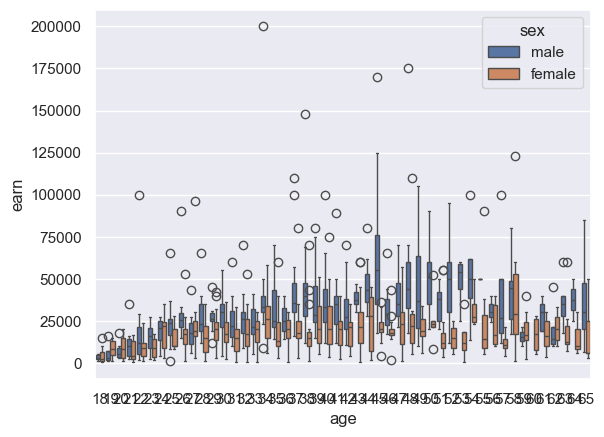

In [19]:
sns.boxplot(data=salaries, x="age", y="earn", hue="sex");

Plotting by raw age results in this busy graph. It is too crowded to tell us anything useful.

To make it more useful [we will bin](https://en.wikipedia.org/wiki/Data_binning) age into age groups.

The bins need to be defined in a way that makes some sense for the level of experience the employee has. We will use _22_ as our first bin because this is usually [the age of graduation](https://nonpartisaneducation.org/Review/Resources/Int__lHigherEd_AppendixA.pdf). After that, we will bin every five years for the first years, to account for rapid promotions and rises that happen in the start of a career, then bin every ten years for later stages in the career, where promotions are rarer.

In [20]:
min_age = salaries["age"].min()
max_age = salaries["age"].max()
salaries["agegroup"] = pd.cut(
    x=salaries["age"], bins=[min_age - 1, 21, 26, 31, 41, 51, 61, max_age]
)

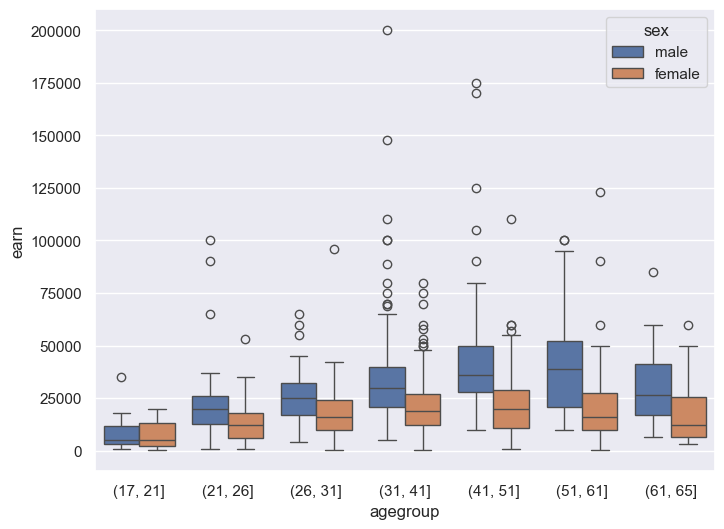

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=salaries, x="agegroup", y="earn", hue="sex");

This plot shows that with the exception of the youngest age group, females earn less on average. More importantly, females earn less in all quartiles and have fewer outliers in the fourth quartile (the higher end of salaries).

### Analyzing education level

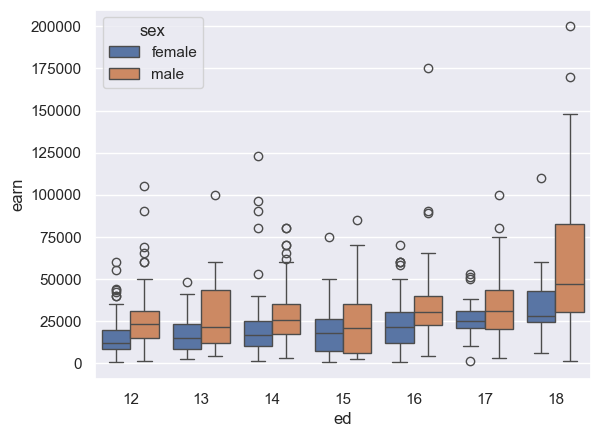

In [22]:
sns.boxplot(data=salaries, x="ed", y="earn", hue="sex");

This plot also shows that females earn less than males on average, and again the quartiles are lower for females.

### Excluding low salaries

When we performed the exploratory data analysis, we noticed some low salaries. Let's check if after we cleaned the dataset they are still there.

In [23]:
salaries.earn.describe()

count       991.000000
mean      24323.319879
std       20334.095131
min         200.000000
25%       12000.000000
50%       20000.000000
75%       30000.000000
max      200000.000000
Name: earn, dtype: float64

We still have the low salaries. These salaries may indicate employees that were not present for the entire period of data collection or may have some special work arrangement. Either way, they may be skewing the analysis.

We will exclude them and check the salaries by education level and age group again.

For the cutoff we will use the first quartile, 12,000 (shown above with `describe()`).

In [24]:
SALARY_CUT_OFF = 12000
lower_salaries = salaries.earn < SALARY_CUT_OFF

print(
    "There are {} employees earning less than {:,} out of {} employess".format(
        lower_salaries.sum(), SALARY_CUT_OFF, len(salaries)
    )
)

There are 236 employees earning less than 12,000 out of 991 employess


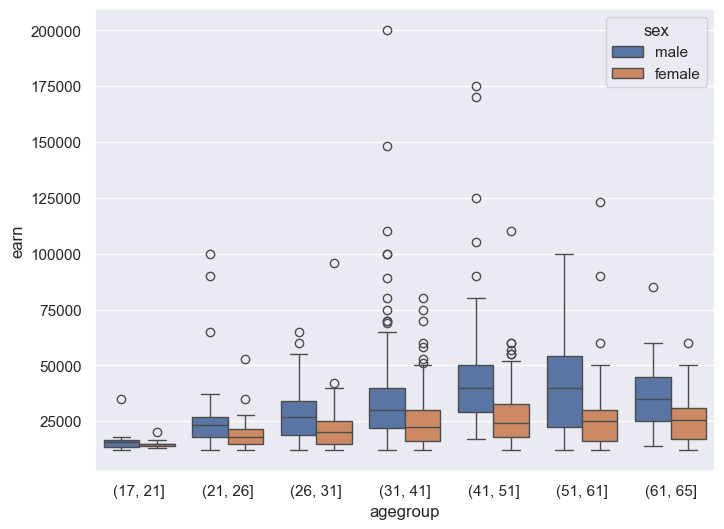

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=salaries[~lower_salaries], x="agegroup", y="earn", hue="sex");

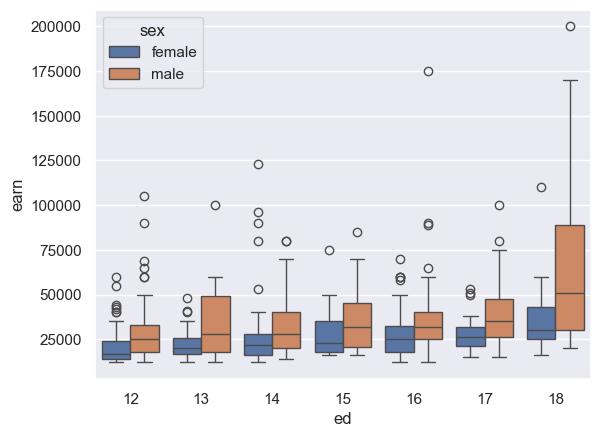

In [26]:
sns.boxplot(data=salaries[~lower_salaries], x="ed", y="earn", hue="sex");

After we exclude the lower salaries, we end up with the same picture: females are paid less on average and in general.

### Conclusions

We collected enough evidence to point to potential gender discrimination in salaries at this company:

- For the same experience level, females make less on average and in general (all quartiles).
- When adjusting for education as a possible explanation, the data also shows that females make less on average and in general for the same education level.

However, we are missing one crucial piece of information: experience in the job. We used _age_ as a proxy for experience. That may not be accurate.

Even with this missing piece of information, when presenting the results to the higher echelons of the company, we can say that:

"_We found strong evidence of gender discrimination, but the data we have is not enough to be conclusive. We recommend as the next step to collect years of experience in the job to complete a better analysis. Until that is done, department heads can also review the salaries of males and females doing the same job in those departments and adjust them accordingly."_

That strikes a balance between "let's collect more data" (a symptom of [_analysis paralysis_](https://en.wikipedia.org/wiki/Analysis_paralysis)), and effectual action.

## Summary

Sometimes data science will not produce a binary outcome ("it is right/wrong"). It is not uncommon to reach a point where we find evidence, but not a conclusive answer to the question we set out to investigate. 

Nevertheless, data science will produce enough results for a call to action.

In this section we cleaned up the dataset, removing outliers that were not relevant for the analysis. To do that we had to first understand the domain of the data we were using (working-age population). We also removed attributes (columns) that were not relevant for the analysis.

Once we had a clean dataset, we collected enough evidence to call for action on possible gender discrimination by using:

- seaborn [`distplot()`](https://seaborn.pydata.org/generated/seaborn.distplot.html) to review the distribution of dataset attributes.
- [Box plots](https://en.wikipedia.org/wiki/Box_plot), with seaborn [`distplot()`](https://seaborn.pydata.org/generated/seaborn.boxplot.html), to inspect details of an attribute's distribution: its quartiles and outliers.
- Pandas `DataFrame` [masks](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html) to filter out rows. For example, to remove employes over a certain age, or below an education level.
- seaborn [`pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to view the relationship of all attributes of a dataset at a glance.
- Pandas' [`cut()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to bin (group) attributes into larger categories.